<a href="https://colab.research.google.com/github/marcomedugno/Baseball-Projects/blob/main/Solving_Baseball's_Sample_Size_Problem_using_K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Solving Baseball's Sample Size Problem using K-Means Clustering*** *with hitter matchup recommender tool*

**Some elements may be hidden in Github's preview mode. Click "Open in Colab" for a more readable experience.*

###**IMPORTING LIBRARIES**

In [ ]:
# @title
!pip install pybaseball > /dev/null 2>&1
!pip install Levenshtein > /dev/null 2>&1
import zipfile
from typing_extensions import DefaultDict
import pandas as pd
import io
from io import StringIO
import numpy as np
import re
from pybaseball import statcast
from pybaseball import cache
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import unicodedata
import Levenshtein as lev

###**INTRODUCTION**

It's nearly impossible to watch an MLB game without hearing the broadcasters say something along the lines of "X hitter owns this pitcher. He is 4 for 7 against him." or "He is ice cold! 0 for his last 10". Any statistician would tell you that these sample sizes are nowhere near large enough to draw any meaningful conclusions, yet broadcasters still cite them. Of course, their job is mainly to entertain and create narratives about what is happening on the field, and small sample size statistics can be entertaining. In fact, fans have actually recorded songs of their favorite small sample size statistics (see below).

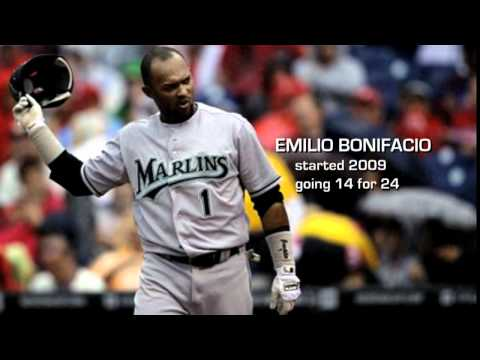

In [ ]:
# @title
from IPython.display import YouTubeVideo
video_id = 'dw9qqvm-LT8'
YouTubeVideo(video_id, width=1000, height=562.5)

As analytics have become more and more ingrained into sports and sports media, there has been debate over the importance of these small sample sizes. This topic was heavily featured in a segment on MLB Now in 2020 when discussing Ji-Man Choi's success against Gerrit Cole:

In [22]:
# @title
from IPython.display import HTML
video_url = "https://dl.dropboxusercontent.com/scl/fi/lblufxs4v8gvwtibct4a2/MLB-Now-on-small-sample-sizes-Made-with-Clipchamp_1705701447900.mp4?rlkey=7lxhadq5u2y2ifne8t9ow40i9&dl=1"
HTML(f'<video width="960" height="540" controls><source src="{video_url}" type="video/mp4"></video>')


Although there are still some traditional managers who will "play the hot hand," many decision-makers understand that these small sample sizes cannot be trusted. Instead, they may look for other ways to increase the hitter's sample size of data versus a particular pitcher. The most common way to do this is by looking at the hitter's performance against a pitcher's handedness. Traditionally, lefty hitters perform worse against lefty pitchers and righty hitters perform worse against righty pitchers.

This is definately a good start when making lineup decisions, as there is a significant correlation between this trend throughout baseball history, and comparing ~500 at bats vs. all lefties is better than comparing 3 at bats vs. one particular lefty. However, this still seems elementary to me, especially in an age with so much data. There is so much more that might make a pitcher easier or harder to hit than what side they throw from. Some players struggle with fastballs. Others may struggle with sidearmers. In an age with so much pitcher data, there's no reason to base decisions on only one attribute.

In this project, I will attempt to find a better way to increase hitter sample sizes, while also incorporating many more attributes than pitcher handedness. I will do this by using a method called K-Means clustering, which essentially is a model that groups instances, pithers in our case, based on their many different traits. So instead of having only 2 groups of pitchers to record batter splits from (righties and lefties), we may now have 3, 4, 5, 6, or more distinct groups of pitchers, each with their own identity.

In the end, we'll even find matchups where a hitter may fare poorly against a certain pitcher handedness, but finds a lot of success against that pitcher's group, and vice versa. Comparing hitting statistics against a group of pitchers that share many unique attributes will give us a much more complete outlook when predicting player success, or making a decision on which player to put in the lineup.

###**DATA COLLECTION**

To be able to evaluate hitters' performance versus different pitcher clusters, I needed a dataset of each hitter-pitcher matchup that occured in 2023. I hoped there would be a public dataset where I could easily pull this from. Unfortunately, there was not. Luckily I found an events zip file from [Retrosheet](https://www.retrosheet.org/datause.html) with full play-by-play descriptions. To get the dataframe we need, I had to heavily manipulate the data as the files used their specific scoring system to describe games in detail. Additionally, the ASCII text files contain records in distinct lines, each beginning with a type designator and ending with DOS newline characters. There are sixteen different record types, each with a unique designator followed by fields separated by commas.

To begin, I wrote a function to download the event files from the Retrosheet website and another to read and concatenate these files. My code parsed this data to track pitchers and batters, extracting their stats and substitutions. I split the data into individual games and extracted player information to create a roster DataFrame. This roster included player IDs, names, positions, and teams, which I then used to identify starting pitchers for each team.

Next, I iterated over the data to categorize each play, focusing on identifying pitchers and batters, and compiled this into a DataFrame. I updated pitcher information during substitutions and filtered out non-play events. To simplify the results, I transformed complex play results into more understandable categories, like "Single" or "Home Run."

Finally, I processed the data into a comprehensive DataFrame, grouping and unstacking results to calculate detailed statistics like at-bats, hits, and on-base percentages. I created a 'batter vs. pitcher' DataFrame, rounding the On-base Plus Slugging (OPS) stats to three decimal places. This DataFrame will be used for further evaluation and insights.







In [ ]:
# @title
pd.options.mode.chained_assignment = None #Supress warning

def download_file(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.content

def read_and_concatenate(zip_content):
    """Read and concatenate .EVA (events american league) and .EVN (events national league) files from a zip archive given as bytes."""
    input_text = ""
    with zipfile.ZipFile(io.BytesIO(zip_content), 'r') as zip_ref:
        for file_info in zip_ref.infolist():
            if file_info.filename.endswith('.EVA') or file_info.filename.endswith('.EVN'):
                with zip_ref.open(file_info, 'r') as file:
                    content = file.read().decode('utf-8')  # Specify encoding if not UTF-8
                    content = content.replace('\r\n', '\n')  # Normalize line endings
                    input_text += content + "\n"
    return input_text

url = 'https://www.retrosheet.org/events/2023eve.zip'  # URL of game event data
zip_content = download_file(url)
baseball_data = read_and_concatenate(zip_content)

def parse_baseball_data(data):
    lines = data.split('\n')
    current_pitchers = {'0': None, '1': None}  # '0' for visiting team, '1' for home team
    pitcher_stats = set()
    game_data = []

    for line in lines:
        parts = line.split(',')

        # Identify starting pitchers
        if parts[0] == 'start' and len(parts) > 5:
            position = parts[5]
            if position == '1':  # Position '1' is the pitcher
                current_pitchers[parts[2]] = parts[1]  # team, player ID

        # Track pitcher stats to confirm they pitched
        elif parts[0] == 'data' and parts[1] == 'er':
            pitcher_stats.add(parts[2])

        # Handle substitutions
        elif parts[0] == 'sub' and len(parts) > 5:
            position = parts[5]
            if position == '1' and parts[1] in pitcher_stats:
                current_pitchers[parts[2]] = parts[1]  # team, player ID

        # Process each play
        elif parts[0] == 'play':
            batter_id = parts[3]
            team_playing = parts[1]
            opposing_team = '1' if team_playing == '0' else '0'
            pitcher_id = current_pitchers[opposing_team]
            result = parts[-1]

            if pitcher_id:  # Only add if we have a pitcher identified
                game_data.append((batter_id, pitcher_id, result))

    return game_data

parsed_data = parse_baseball_data(baseball_data)
for event in parsed_data:
    print(event)

# Split the input text into lines
lines = baseball_data.split('\n')

# Initialize a list to store the data strings
data_strings = []

# Initialize a variable to store the current data string
current_data_string = ""

# Loop through the lines and extract the data strings
for line in lines:
    if line.startswith("id,"):
        # If a new "id," line is encountered, add the previous data string to the list
        if current_data_string:
            data_strings.append(current_data_string)
        # Start a new data string with the current line
        current_data_string = line + '\n'
    else:
        # Add the current line to the current data string
        current_data_string += line + '\n'

# Add the last data string to the list
if current_data_string:
    data_strings.append(current_data_string)

# Define a function to process baseball data
def process_baseball_data(baseball_data):
    # Define empty lists to store PlayerID and PlayerName
    player_ids = []
    player_names = []
    player_positions = []

    # Split the text block into lines
    lines = baseball_data.split('\n')

    # Loop through the lines to extract PlayerID and PlayerName from lines starting with "start," or "sub,"
    for line in lines:
        if line.startswith("start,") or line.startswith("sub,"):
            parts = line.split(",")
            if len(parts) >= 3:
                player_id = parts[1]
                player_name = parts[2].strip('"')
                player_position = parts[5]
                player_ids.append(player_id)
                player_names.append(player_name)
                player_positions.append(player_position)

    # Create a DataFrame
    roster = pd.DataFrame({
        "PlayerID": player_ids,
        "Player": player_names,
        "Position": player_positions
    })

    player_teams = []

    # Split the text block into lines
    lines = baseball_data.split('\n')

    # Loop through the lines to extract PlayerID and PlayerName from lines starting with "start," or "sub,"
    for line in lines:
        if line.startswith("start,") or line.startswith("sub,"):
            parts = line.split(",")
            player_team = parts[3]
            player_teams.append(player_team)

    # Add the 'Teams' column to the DataFrame 'df'
    roster['Teams'] = player_teams

        # Define a regular expression pattern to match the desired text

    pattern = r'info,visteam,(.*?)\n'

    # Use re.search to find the first match
    match = re.search(pattern, baseball_data)

    # Extract the matched text and store it as away_team
    away_team = match.group(1)

    pattern = r'info,hometeam,(.*?)\n'

    # Use re.search to find the first match
    match = re.search(pattern, baseball_data)

    # Extract the matched text and store it as home_team
    home_team = match.group(1)

    roster['Teams'] = roster['Teams'].replace('^0$', away_team, regex=True)
    roster['Teams'] = roster['Teams'].replace('1', home_team, regex=True)

    # Check if 'PlayerID' is unique
    if not roster['PlayerID'].is_unique:
        # Handle non-unique indices, e.g., by dropping duplicates
        roster = roster.drop_duplicates(subset='PlayerID')

    # Check if 'Player' is unique
    if not roster['Player'].is_unique:
        # Handle non-unique indices, e.g., by dropping duplicates
        roster = roster.drop_duplicates(subset='Player')

    # Find the 10th occurrence of ',"' to find the Away Team's Starting Pitcher. Always Listed 10th in Starting Lineup.
    index = -1
    for i in range(10):
        index = baseball_data.find(',"', index + 1)
    if index != -1:
        end_index = baseball_data.find('"', index + 2)
        if end_index != -1:
            away_pitcher = baseball_data[index + 2:end_index]
        else:
            print("Could not find the closing '\"'")
    else:
        print("Could not find the 10th ',\"'")

    # Find the 20th occurrence of ',"' to find the Home Team's Starting Pitcher. Always Listed 20th in Starting Lineup.
    index = -1
    for i in range(20):
        index = baseball_data.find(',"', index + 1)
    if index != -1:
        end_index = baseball_data.find('"', index + 2)
        if end_index != -1:
            home_pitcher = baseball_data[index + 2:end_index]
        else:
            print("Could not find the closing '\"'")
    else:
        print("Could not find the 10th ',\"'")


    # Split the data into lines
    lines = baseball_data.split('\n')

    # Initialize an empty list to store event data
    events = []

    # Initialize variables to keep track of the current event
    current_event = None
    current_event_data = {}

    # Iterate through the lines and extract the data
    for line in lines:
        parts = line.split(',')
        key = parts[0]
        value = ','.join(parts[1:])

        if key == "play" or key == "sub":
            if current_event:
                current_event_data['event_data'] = ','.join(current_event_data['event_data'])
                events.append(current_event_data)
            current_event = key
            current_event_data = {'event_type': key, 'event_data': [value]}
        else:
            if 'event_data' not in current_event_data:
                current_event_data['event_data'] = []
            current_event_data['event_data'].append(key + ',' + value)

    # Ensure the last event is added to the list
    if current_event_data:
        current_event_data['event_data'] = ','.join(current_event_data['event_data'])
        events.append(current_event_data)

    # Remove any extra data from the last event
    if len(events) > 0 and 'data' in events[-1]['event_data']:
        events[-1]['event_data'] = events[-1]['event_data'].split('data')[0].strip(',')

    # Create a DataFrame from the list of event dictionaries
    df = pd.DataFrame(events)

    # Split the "event_data" column by commas and expand into separate columns
    split_data = df['event_data'].str.split(',', expand=True)

    # Rename the new columns
    split_data.columns = [f'event_data_{i+1}' for i in range(split_data.shape[1])]

    # Concatenate the split_data DataFrame with the original DataFrame
    df = pd.concat([df, split_data], axis=1)

    df['BatterName'] = df['event_data_3'].map(roster.set_index('PlayerID')['Player'])
    df['BatterTeam'] = df['event_data_3'].map(roster.set_index('PlayerID')['Teams'])

    df['Pitcher'] = df.apply(lambda row: home_pitcher if row['BatterTeam'] == away_team else away_pitcher, axis=1)

    # # Replace " in the 'event_data_3' column
    df['event_data_2'] = df['event_data_2'].str.replace('"', '')

    df['SubTeam'] = df['event_data_2'].map(roster.set_index('Player')['Teams'])


    # Function to update 'Pitcher' column for the home team
    def update_pitcher(df, roster, home_team, away_team):
        # Initialize the current pitcher to None
        current_pitcher = None

        # Iterate over the DataFrame rows
        for index, row in df.iterrows():
            # Check if the event is a substitution and update the current pitcher
            if row['event_type'] == 'sub' and row['event_data_5'] == '1':
                # Retrieve the current pitcher's team from the 'roster' DataFrame
                pitcher_team = roster.loc[roster['Player'] == row['event_data_2'], 'Teams'].values[0]
                # Check if the substitution is for the home team
                if pitcher_team == home_team:
                    current_pitcher = row['event_data_2']

            # Update the 'Pitcher' column if the current pitcher is set and BatterTeam is not the home team
            if current_pitcher is not None and row['BatterTeam'] != home_team:
                df.at[index, 'Pitcher'] = current_pitcher

        return df

    df = update_pitcher(df, roster, home_team, away_team)

    # Function to update 'Pitcher' column for the away team
    def update_pitcher(df, roster, home_team, away_team):
        # Initialize the current pitcher to None
        current_pitcher_home = None
        current_pitcher_away = None

        # Iterate over the DataFrame rows
        for index, row in df.iterrows():
            # Check if the event is a substitution and update the current pitcher for the home team
            if row['event_type'] == 'sub' and row['event_data_5'] == '1':
                # Retrieve the pitcher's name
                pitcher_name = row['event_data_2']
                # Retrieve the pitcher's team from the 'roster' DataFrame
                pitcher_team = roster.loc[roster['Player'] == pitcher_name, 'Teams'].values[0]
                # Update the current pitcher based on the team
                if pitcher_team == home_team:
                    current_pitcher_home = pitcher_name
                elif pitcher_team == away_team:
                    current_pitcher_away = pitcher_name

            # Update the 'Pitcher' column for the home team at-bats
            if current_pitcher_away is not None and row['BatterTeam'] == home_team:
                df.at[index, 'Pitcher'] = current_pitcher_away
            # Update the 'Pitcher' column for the away team at-bats
            elif current_pitcher_home is not None and row['BatterTeam'] == away_team:
                df.at[index, 'Pitcher'] = current_pitcher_home

        return df

    df = update_pitcher(df, roster, home_team, away_team)

    # Remove events that are not plays, such as substitutions and 'New Pitcher' events
    df = df[df['event_type'] != 'sub']
    df = df[df['event_data_6'] != 'NP']

    consecutive_duplicates = df['BatterName'] == df['BatterName'].shift(-1)

    # Keep the last row of each consecutive group of duplicates. This will keep the actual result of the batters' at bats
    df = df[~consecutive_duplicates | consecutive_duplicates.shift(1, fill_value=False)]

    df.reset_index(drop=True, inplace=True)

    #event_data_6 contains results, however they are very complex. A typical result might look like '64(1)3/GDP/G6'.  We need to simplify.
    df = df[~df['event_data_6'].str.startswith(('CS', 'PO'))] #remove Caught Stealing and Pickoff plays
    df.loc[df['event_data_6'].str.startswith('HP'), 'event_data_6'] = 'Hit by Pitch'
    df.loc[df['event_data_6'].str.startswith('S'), 'event_data_6'] = 'Single'
    df.loc[df['event_data_6'].str.startswith('D'), 'event_data_6'] = 'Double'
    df.loc[df['event_data_6'].str.startswith('T'), 'event_data_6'] = 'Triple'
    df.loc[df['event_data_6'].str.startswith('HR'), 'event_data_6'] = 'Home Run'
    df.loc[df['event_data_6'].str.startswith('W'), 'event_data_6'] = 'Walk'
    df.loc[df['event_data_6'].str.startswith('C/E'), 'event_data_6'] = 'Error'
    df['event_data_6'] = df['event_data_6'].str.replace('.*/SF/.*', 'Sac Fly', regex=True)
    df['event_data_6'] = df['event_data_6'].str.replace('.*/SH/.*', 'Sac Hit', regex=True)


    valid_event_types = ["Hit by Pitch", "Single", "Double", "Triple", "Home Run", "Walk", "Error","Sac Fly","Sac Hit"]
    df['event_data_6'] = df['event_data_6'].apply(lambda x: x if x in valid_event_types else "Out")
    df['PitcherID'] = df['Pitcher'].map(roster.set_index('Player')['PlayerID'])

    clean_df = df[['event_data_3', 'PitcherID', 'BatterName', 'Pitcher', 'event_data_6']].copy()
    clean_df.columns = ['BatterID', 'PitcherID', 'BatterName', 'PitcherName', 'Result']
    return(clean_df)

 # Create an empty list to store the results from each string variable
consolidated_clean_dfs = []

# Loop through each variable in data_strings
for i, data_string in enumerate(data_strings, start=1):
    # print(f"Processing data_string {i}")
    clean_df = process_baseball_data(data_string)
    consolidated_clean_dfs.append(clean_df)

# Concatenate all the DataFrames from different string variables
final_clean_df = pd.concat(consolidated_clean_dfs, ignore_index=True)

# Group by the first four columns and unstack 'Result' to create the new columns
grouped_df = final_clean_df.groupby(['BatterID', 'PitcherID', 'BatterName', 'PitcherName', 'Result']).size()
pivot_df = grouped_df.unstack(fill_value=0).reset_index()

# Calculate stats from result
pivot_df.columns.name = None

pivot_df['At Bats'] = pivot_df[['Out', 'Double', 'Home Run', 'Single', 'Triple']].sum(axis=1)
pivot_df['Plate Appearances'] = pivot_df[['At Bats', 'Walk', 'Sac Fly', 'Error','Hit by Pitch','Sac Hit']].sum(axis=1)
pivot_df['Hits'] = pivot_df[['Double', 'Home Run', 'Single', 'Triple']].sum(axis=1)
pivot_df['Hits'] = pivot_df[['Double', 'Home Run', 'Single', 'Triple']].sum(axis=1)
pivot_df['Total Bases'] = (pivot_df['Single'] +
                           2 * pivot_df['Double'] +
                           3 * pivot_df['Triple'] +
                           4 * pivot_df['Home Run'])

# Calculating On-base Percentage (OBP)
pivot_df['OBP'] = (pivot_df['Hits'] + pivot_df['Walk'] + pivot_df['Hit by Pitch']) / (pivot_df['At Bats'] + pivot_df['Walk'] + pivot_df['Hit by Pitch'] + pivot_df['Sac Fly'])

# Calculating Slugging Percentage (SLG)
pivot_df['SLG'] = pivot_df['Total Bases'] / pivot_df['At Bats']

# Calculating On-base Plus Slugging (OPS)
pivot_df['OPS'] = pivot_df['OBP'] + pivot_df['SLG']

pivot_df = pivot_df.sort_values(by='At Bats', ascending=False)

selected_columns = ['BatterID','PitcherID','BatterName','PitcherName','At Bats','OPS']

batter_vs_pitcher_df = pivot_df[selected_columns]

batter_vs_pitcher_df['OPS'] = batter_vs_pitcher_df['OPS'].round(3)

# Dataframe to be used for later evaluation
batter_vs_pitcher_df.head(10)

,BatterID,PitcherID,BatterName,PitcherName,At Bats,OPS
5345,arral001,willt002,Luis Arraez,Trevor Williams,13,1.154
9353,bichb001,coleg001,Bo Bichette,Gerrit Cole,13,0.154
61824,perdg001,webbl001,Geraldo Perdomo,Logan Webb,13,0.385
76153,sprig001,coleg001,George Springer,Gerrit Cole,13,0.368
43543,kwans001,grays001,Steven Kwan,Sonny Gray,13,0.385
51487,mcmar001,webbl001,Ryan McMahon,Logan Webb,13,0.385
72867,semim001,detmr001,Marcus Semien,Reid Detmers,13,0.819
67259,robel002,allel003,Luis Robert Jr.,Logan Allen,12,1.000
4845,arozr001,coleg001,Randy Arozarena,Gerrit Cole,12,0.750
67386,robel002,lylej001,Luis Robert Jr.,Jordan Lyles,12,1.083



I then used Statcast's API to gather pitch tracking data for the 2023 MLB season. My goal was to compute average statistics for each pitcher.

Here's a breakdown of each step and the attributes in the final pitcher stats dataset:

1.   **Data Collection:** I collected data from March 30 to October 1, 2023, using the statcast function.

2.   **Filtering Outlier Pitches:** I excluded pitches below 60 mph, as well as knuckleballs and eephus pitches to remove unusually slow pitches, which are not representative of a pitcher's standard arsenal. Often, these pitches were thrown by position players with no experience and were simply in to eat up innings, not to pitch effectively.

3.   **Simplifying Pitch Types:** I categorized pitches into three main types: Breaking, Fastball, and Offspeed. This simplification helps in analyzing pitchers based on these broad categories rather than numerous specific pitch types.

4.   **Rearranging Player Names:** To match with the previous dataset, I rearranged player names from 'Last, First' to 'First Last'.

5.   **Calculating Statistics:** I used a custom function to calculate various statistics for each pitcher. The attributes in the final dataset include:

*   ***total_pitches:*** Total number of pitches thrown by the pitcher.
* ***%_fastball, %_offspeed, %_breaking:*** The percentage of each pitch type used by the pitcher.
*   ***release_speed_[pitch_type]:*** The average release speed for each pitch type.
*   ***spin_dir_[pitch_type]:*** The average spin axis for each pitch type, indicating the direction of the spin.
*   ***spin_rate_[pitch_type]:*** The average spin rate for each pitch type, reflecting how fast the ball spins.
*   ***release_pos_x_avg, release_pos_z_avg:*** The average horizontal and vertical release positions of the pitches.
*   ***release_extension_avg:*** The average extension of the pitcher's arm at release.
*   ***plate_x_[pitch_type], plate_z_[pitch_type]:*** The average horizontal and vertical location where the pitch crosses home plate for each pitch type.


6.     **Data Cleaning and Filtering:** I ensured all columns were numeric, replaced missing values with the mean, and filtered out pitchers with less than 100 pitches to focus on those with sufficient data for analysis.

7.     **Sorting and Display:** Finally, I sorted the data by the total number of pitches thrown and displayed the top 10 entries:

In [ ]:
# @title
# Enable caching
cache.enable()
df = statcast(start_dt="2023-03-30", end_dt="2023-10-01")

# Filter out pitches under 60 mph
df = df[df['release_speed'] >= 60]

# Group pitch types into fastball, breaking ball or offspeed pitches
breaking_types = ['CS', 'CU', 'KC', 'SL', 'ST', 'SV']
fastball_types = ['FC', 'FF', 'SI']
offspeed_types = ['CH', 'FO', 'FS', 'SC']

df['pitch_type'] = df['pitch_type'].replace(breaking_types, 'Breaking')
df['pitch_type'] = df['pitch_type'].replace(fastball_types, 'Fastball')
df['pitch_type'] = df['pitch_type'].replace(offspeed_types, 'Offspeed')
remove_types = ['EP', 'FA', 'KN', 'PO']
df = df[~df['pitch_type'].isin(remove_types)]

# Rearrange the name format
def rearrange_name(name):
    if pd.isna(name) or ',' not in name:
        return name
    last_name, first_name = name.split(', ')
    return f"{first_name} {last_name}"

# Apply the function to the 'player_name' column
df['player_name'] = df['player_name'].apply(rearrange_name)


# Calculate the required statistics within each group
def calculate_stats(group):
    total_pitches = len(group)
    percent_fastball = (group['pitch_type'] == 'Fastball').mean()
    percent_offspeed = (group['pitch_type'] == 'Offspeed').mean()
    percent_breaking = (group['pitch_type'] == 'Breaking').mean()

    # Calculate averages for the specified conditions
    averages = group.groupby('pitch_type').agg({'release_speed': 'mean', 'spin_axis': 'mean', 'release_spin_rate': 'mean', 'plate_x': 'mean', 'plate_z': 'mean'}).to_dict()

    # Extract averages for each pitch type
    def get_average(pitch_type, metric):
        return averages.get(metric, {}).get(pitch_type, None)

    return pd.Series({
        'total_pitches': total_pitches,
        '%_fastball': percent_fastball,
        '%_offspeed': percent_offspeed,
        '%_breaking': percent_breaking,
        'release_speed_fastball': get_average('Fastball', 'release_speed'),
        'release_speed_offspeed': get_average('Offspeed', 'release_speed'),
        'release_speed_breaking': get_average('Breaking', 'release_speed'),
        'spin_dir_fastball': get_average('Fastball', 'spin_axis'),
        'spin_dir_offspeed': get_average('Offspeed', 'spin_axis'),
        'spin_dir_breaking': get_average('Breaking', 'spin_axis'),
        'spin_rate_fastball': get_average('Fastball', 'release_spin_rate'),
        'spin_rate_offspeed': get_average('Offspeed', 'release_spin_rate'),
        'spin_rate_breaking': get_average('Breaking', 'release_spin_rate'),
        'release_pos_x_avg': group['release_pos_x'].mean(),
        'release_pos_z_avg': group['release_pos_z'].mean(),
        'release_extension_avg': group['release_extension'].mean(),
        'plate_x_fastball': get_average('Fastball', 'plate_x'),
        'plate_x_offspeed': get_average('Offspeed', 'plate_x'),
        'plate_x_breaking': get_average('Breaking', 'plate_x'),
        'plate_z_fastball': get_average('Fastball', 'plate_z'),
        'plate_z_offspeed': get_average('Offspeed', 'plate_z'),
        'plate_z_breaking': get_average('Breaking', 'plate_z')
    })

# Group by pitcher_id and pitcher_name, then apply the custom function
pitcher_stats = df.groupby(['pitcher', 'player_name','p_throws']).apply(calculate_stats)

# Reset index to make 'pitcher' and 'player_name' columns
pitcher_stats.reset_index(inplace=True)

# Replace NAs with the mean of each column
for column in pitcher_stats.columns:
    if pitcher_stats[column].dtype == 'float64' or pitcher_stats[column].dtype == 'int64':
        pitcher_stats[column].fillna(pitcher_stats[column].mean(), inplace=True)

# Remove pitchers who threw less than 100 pitches
pitcher_stats_with_pitchers_under_100_pitches = pitcher_stats
pitcher_stats = pitcher_stats[pitcher_stats['total_pitches'] >= 100]

# Convert all columns to numeric, except 'pitcher' and 'player_name'
numeric_columns = pitcher_stats.columns.drop(['pitcher', 'player_name','p_throws'])
pitcher_stats[numeric_columns] = pitcher_stats[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Replace NAs with the mean for each numeric column
for column in numeric_columns:
    mean_value = pitcher_stats[column].mean()
    pitcher_stats[column].fillna(mean_value, inplace=True)

# Sort by pitches thrown
pitcher_stats = pitcher_stats.sort_values(by='total_pitches', ascending=False)

# Display the resulting DataFrame
pitcher_stats.head(10)

This is a large query, it may take a moment to complete


100%|██████████| 186/186 [05:39<00:00,  1.83s/it]


,pitcher,player_name,p_throws,total_pitches,%_fastball,%_offspeed,%_breaking,release_speed_fastball,release_speed_offspeed,release_speed_breaking,...,spin_rate_breaking,release_pos_x_avg,release_pos_z_avg,release_extension_avg,plate_x_fastball,plate_x_offspeed,plate_x_breaking,plate_z_fastball,plate_z_offspeed,plate_z_breaking
57,543037,Gerrit Cole,R,3281.0,0.600122,0.071015,0.328863,96.195074,89.090987,86.848656,...,2630.610751,-2.021439,5.924249,6.288045,0.069259,-0.516223,0.476460,2.805891,1.866609,1.711094
386,656302,Dylan Cease,R,3262.0,0.431637,0.030349,0.538013,95.564205,74.597980,84.552023,...,2751.845014,-1.416668,6.157781,6.302791,0.199986,-0.338586,0.450387,2.889453,2.298889,1.598114
572,668678,Zac Gallen,R,3248.0,0.599138,0.139470,0.261392,92.930730,86.823400,83.146996,...,2458.865248,-2.792500,5.906786,6.591780,0.044908,-0.367263,0.205477,2.605257,1.615563,1.364441
272,622491,Luis Castillo,R,3207.0,0.622700,0.155909,0.221391,96.144567,88.347400,85.678310,...,2346.553495,-2.482544,5.092401,5.555257,-0.064487,-0.366820,0.463423,2.792729,1.714840,1.773676
103,571945,Miles Mikolas,R,3197.0,0.503597,0.053800,0.442602,93.002422,84.369186,81.617668,...,2405.122957,-2.087373,6.553431,6.400094,0.031404,-0.378081,0.426191,2.662342,2.066453,1.994261
221,608337,Lucas Giolito,R,3190.0,0.419436,0.282759,0.297806,93.106502,80.927273,83.655368,...,1995.998945,-1.271966,6.325906,6.795266,-0.065994,-0.268437,0.507242,2.929268,1.881563,1.760747
433,657277,Logan Webb,R,3182.0,0.372407,0.416091,0.211502,92.330549,87.456118,84.278009,...,2559.030395,-1.284252,5.020965,6.961195,0.145443,0.111080,0.508425,2.539983,1.673014,1.778767
189,605483,Blake Snell,L,3168.0,0.486427,0.184343,0.329230,95.510772,86.734418,83.925599,...,2377.215931,2.120499,6.593150,6.876705,-0.006911,0.644315,-0.402522,2.643848,1.789041,1.091975
14,458681,Lance Lynn,R,3167.0,0.794127,0.069782,0.136091,91.162187,84.880995,81.801856,...,2487.655012,-3.100808,5.573461,6.558091,-0.004513,-0.797783,0.430046,2.709781,1.763529,1.664548
85,554430,Zack Wheeler,R,3155.0,0.758796,0.004120,0.237084,94.710067,90.753846,82.934492,...,2686.469169,-2.016510,5.397113,7.174168,-0.008467,-0.539231,0.411364,2.639929,1.296923,1.451136


###**PREPROCESSING STEPS TO OPTIMIZE K-MEANS RESULTS**

In preparing my dataset for K-Means clustering, I checked for multicollinearity among the features. Multicollinearity can lead to bias in the model by giving similar features too much weight. To investigate this, I started by creating a correlation matrix for each of my features.

I found that my correlation heatmap showed several pairs of closely related features. For instance, the features for spin direction of different pitches (like spin_dir_fastball, spin_dir_offspeed, spin_dir_breaking) were closely linked. To handle this, I calculated the ratios of these spin directions. This helped me represent the differences in spin direction between pitch types, reducing the multicollinearity issue.

I created three new ratio features: spin_dir_ratio_fastball_offspeed, spin_dir_ratio_fastball_breaking, and spin_dir_ratio_offspeed_breaking. To avoid dividing by zero, I added a tiny amount (1e-6) to the denominator in cases where a pitch type was missing. After making these new features, I removed the original spin direction features to streamline my dataset and focus on these new features, enhancing the reliability of my clustering analysis.

However, I noticed that multicollinearity was still a problem between 'spin_dir_ratio_fastball_breaking' and 'spin_dir_ratio_offspeed_breaking'. To solve this, I introduced a new feature called 'diff_spin_dir_ratio_fastball_offspeed' and removed the two problematic columns. This new feature combines the correlated ratios into one, reducing dependence and improving the model's robustness and interpretability. This change also enhanced model performance and analysis.

The final DataFrame, named pitcher_stats, now includes these improved ratio features with reduced multicollinearity issues. This will provide a stronger basis for clustering pitchers based on their pitching styles.


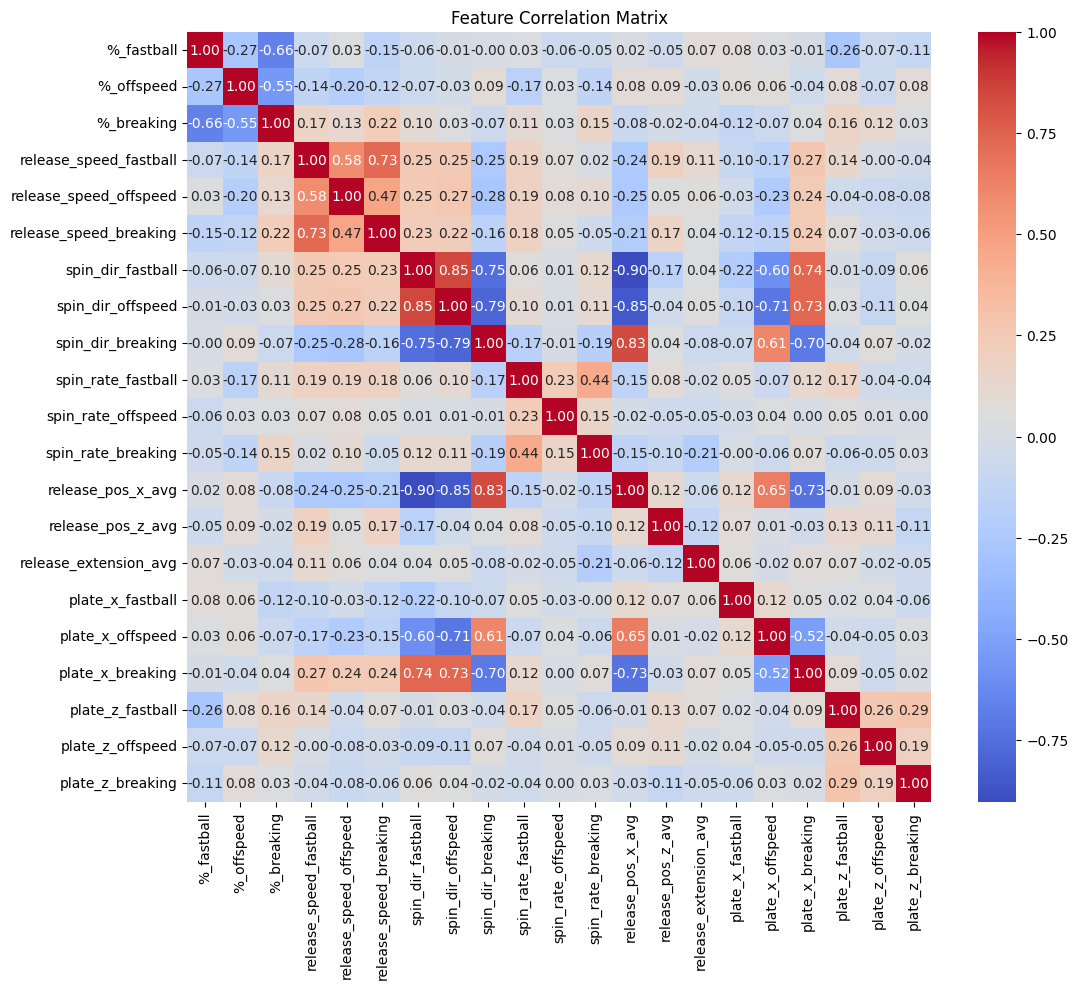

[('spin_dir_fastball', 'spin_dir_offspeed', 0.8485172111196907),
 ('spin_dir_fastball', 'spin_dir_breaking', -0.7519482556970618),
 ('spin_dir_fastball', 'release_pos_x_avg', -0.9018684511716047),
 ('spin_dir_offspeed', 'spin_dir_breaking', -0.7860665494303973),
 ('spin_dir_offspeed', 'release_pos_x_avg', -0.8456343198270913),
 ('spin_dir_breaking', 'release_pos_x_avg', 0.8316144816497308)]

In [ ]:
# @title
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Selecting the features from '%_fastball' to the last column for checking multicollinearity
features = pitcher_stats.loc[:, '%_fastball':]

# Calculating the correlation matrix
corr_matrix = features.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Find the pairs of features where the absolute value of the correlation coefficient is greater than 0.75
high_corr_var = np.where(np.abs(corr_matrix) > 0.75)
# Exclude the diagonal elements by removing pairs where the features are the same
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr_var) if x != y and x < y]

high_corr_var

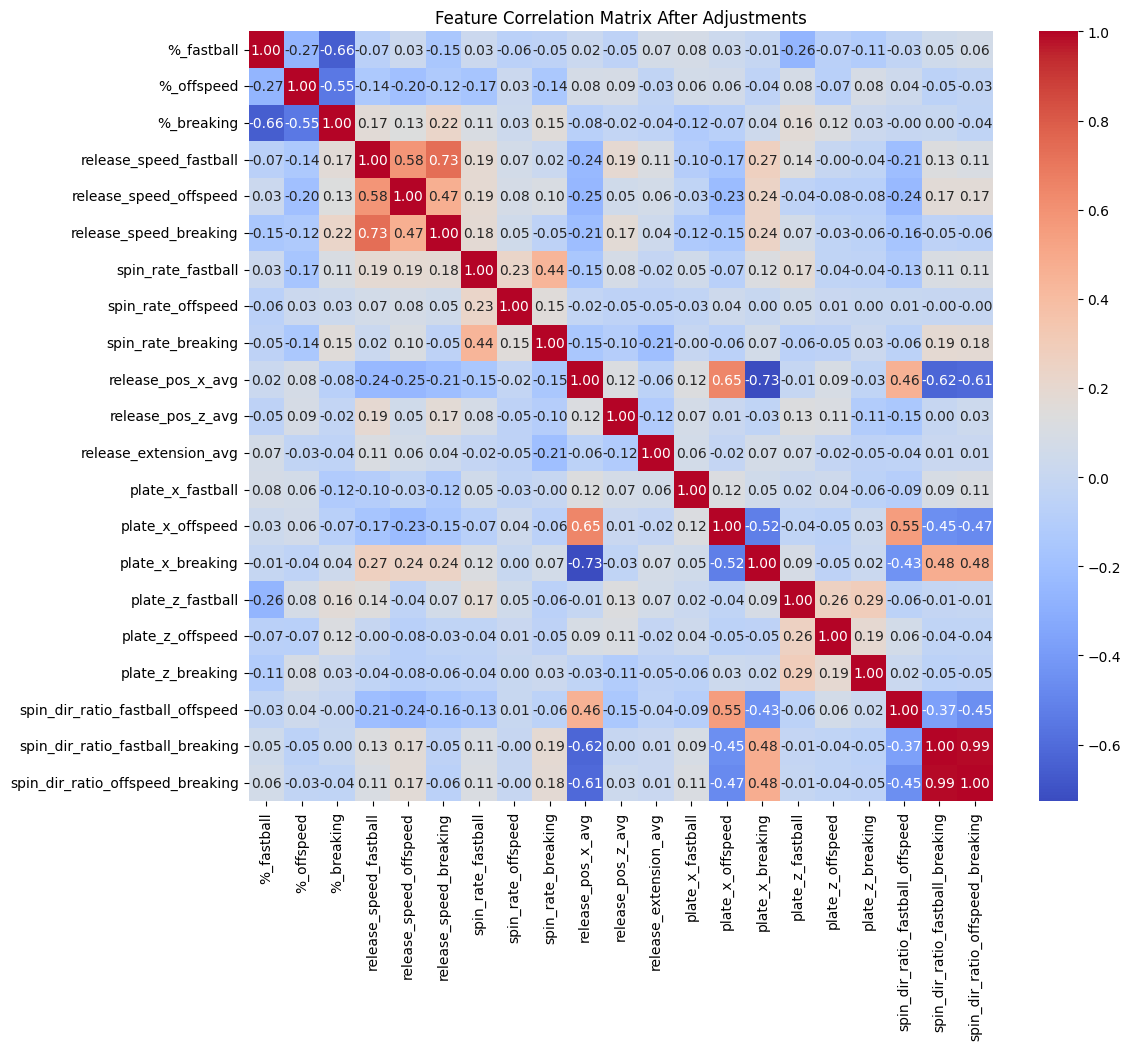

[('spin_dir_ratio_fastball_breaking',
  'spin_dir_ratio_offspeed_breaking',
  0.9894337637425555)]

In [ ]:
# @title
# Calculate the ratio features, add a small number to the denominator to avoid division by zero
pitcher_stats['spin_dir_ratio_fastball_offspeed'] = pitcher_stats['spin_dir_fastball'] / (pitcher_stats['spin_dir_offspeed'] + 1e-6)
pitcher_stats['spin_dir_ratio_fastball_breaking'] = pitcher_stats['spin_dir_fastball'] / (pitcher_stats['spin_dir_breaking'] + 1e-6)
pitcher_stats['spin_dir_ratio_offspeed_breaking'] = pitcher_stats['spin_dir_offspeed'] / (pitcher_stats['spin_dir_breaking'] + 1e-6)

# Check for any infinite values that may have resulted from division by zero and replace them with NaN
pitcher_stats.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop the original spin direction features to reduce multicollinearity
pitcher_stats.drop(['spin_dir_fastball', 'spin_dir_offspeed', 'spin_dir_breaking'], axis=1, inplace=True)

# Selecting the features from '%_fastball' to the last column for checking multicollinearity
features = pitcher_stats.loc[:, '%_fastball':]

# Calculate the correlation matrix
corr_matrix = features.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix After Adjustments')
plt.show()

# Find the pairs of features where the absolute value of the correlation coefficient is greater than 0.75
high_corr_var = np.where(np.abs(corr_matrix) > 0.75)
# Exclude the diagonal elements by removing pairs where the features are the same
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr_var) if x != y and x < y]

high_corr_var

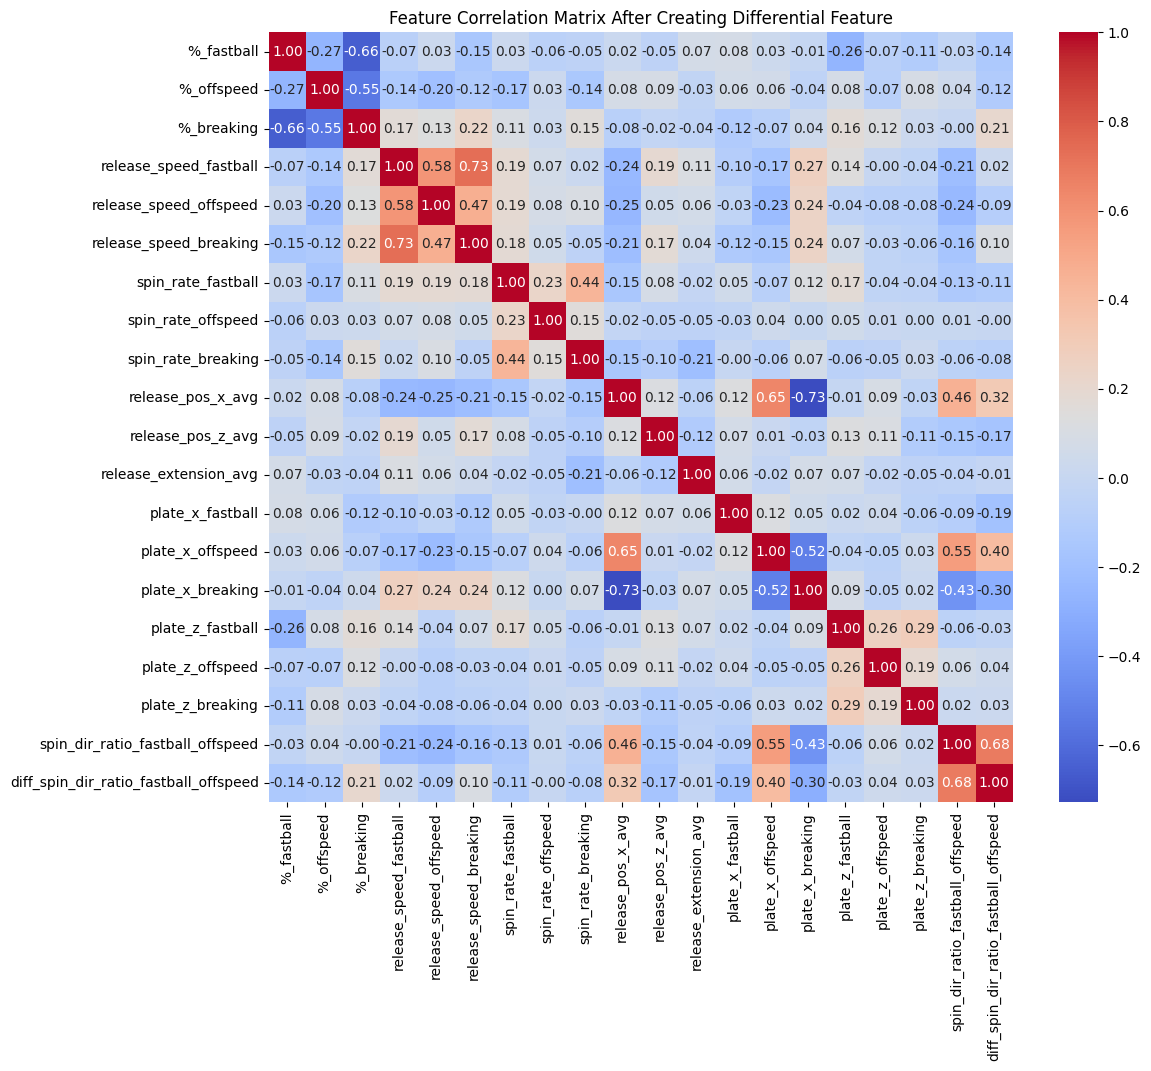

[]

In [ ]:
# @title
# Create a differential feature
pitcher_stats['diff_spin_dir_ratio_fastball_offspeed'] = (pitcher_stats['spin_dir_ratio_fastball_breaking'] -
                                                          pitcher_stats['spin_dir_ratio_offspeed_breaking'])

# Drop the individual ratio features to reduce multicollinearity
pitcher_stats.drop(['spin_dir_ratio_fastball_breaking', 'spin_dir_ratio_offspeed_breaking'], axis=1, inplace=True)

# Selecting the features from '%_fastball' to the last column for checking multicollinearity
features = pitcher_stats.loc[:, '%_fastball':]

# Calculate the correlation matrix
corr_matrix = features.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix After Creating Differential Feature')
plt.show()

# Find the pairs of features where the absolute value of the correlation coefficient is greater than 0.75
high_corr_var = np.where(np.abs(corr_matrix) > 0.75)
# Exclude the diagonal elements by removing pairs where the features are the same
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr_var) if x != y and x < y]

high_corr_var

I then further optimized my dataset, which involved two main steps: standardization and dimensionality reduction. In the first step, I standardized the features in my dataset using the StandardScaler from the scikit-learn library. This process adjusts each feature to have a mean of zero and a standard deviation of one, a common requirement for many machine learning models. By applying the fit_transform method to my features, I calculated the necessary parameters and transformed my data into scaled features.

Next, I used Principal Component Analysis (PCA) for dimensionality reduction. I configured PCA to preserve 95% of the variance in my dataset. This means that PCA reduces the number of dimensions or features in my dataset but still retains 95% of the original information. The way PCA works is quite interesting: it doesn't just remove specific features. Instead, it combines them into new features called principal components. These components are constructed to capture the most important information in the dataset.

In [ ]:
# @title
#Standardization
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Applying PCA to reduce dimensions while retaining 95% of the variance
pca = PCA(n_components=0.95)
reduced_features = pca.fit_transform(scaled_features)

###**PERFORMING THE K-MEANS CLUSTERING**

To determine the optimal number of clusters (K value) for K-Means clustering, I utilized the Elbow Method. I iterated over a range of K values from 1 to 10, applying K-Means clustering for each value and calculating the inertia, which is the sum of squared distances of samples to their closest cluster center. I then plotted these inertia values against the corresponding K values. To identify the elbow point, which indicates the optimal K, I implemented an additional step. I calculated the angles formed by each point with its neighbors on the plot. The point where the maximum angle is observed represents the elbow. This step is somewhat unnecessary, as you can often visually tell the K value from the plot. From the plot, it appears that the optimal K value is 5, as this is where the inertia begins to decrease at a slower rate, indicating diminishing returns on increasing the number of clusters. This point is distinctly marked on the plot.

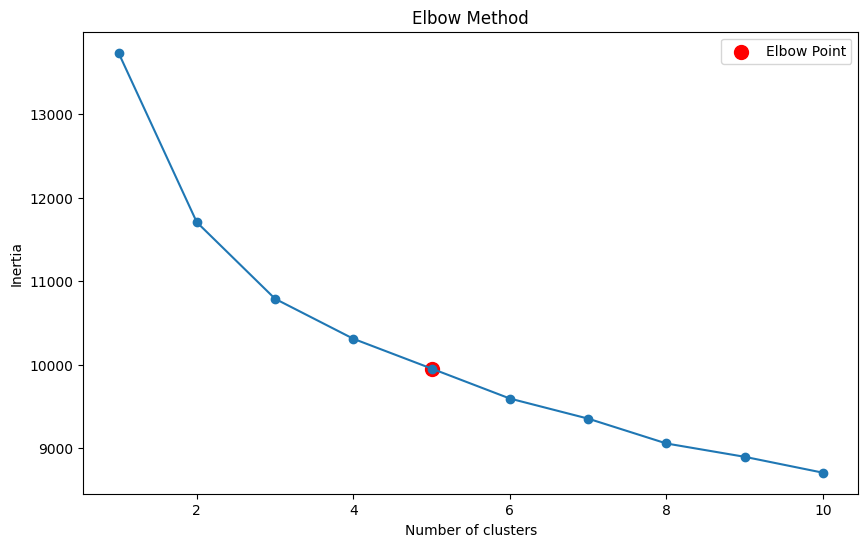

In [ ]:
# @title
# Suppress specific FutureWarnings from sklearn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Step 4: Determining the Number of Clusters (k) using the Elbow Method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    inertia.append(kmeans.inertia_)

# Function to calculate the angle between three points
def calculate_angle(p1, p2, p3):
    a = np.array(p1)
    b = np.array(p2)
    c = np.array(p3)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Calculate the angles
angles = []
for i in range(1, len(inertia)-1):
    angle = calculate_angle([k_values[i-1], inertia[i-1]],
                            [k_values[i], inertia[i]],
                            [k_values[i+1], inertia[i+1]])
    angles.append(angle)

# Find the elbow point (the point with the maximum angle)
elbow_point_index = np.argmax(angles) + 1 # +1 because we started from 1
elbow_point_k = k_values[elbow_point_index]
elbow_point_inertia = inertia[elbow_point_index]

# Plotting the elbow plot with the elbow point highlighted
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.scatter(elbow_point_k, elbow_point_inertia, color='red', s=100, label='Elbow Point')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.legend()
plt.show()


I applied K-Means clustering to group pitchers into five clusters, based on the optimal number of clusters determined previously using the Elbow Method. I then fit the K-Means model with five clusters and assigned each pitcher to one of these clusters. To make the results interpretable, I created a DataFrame that links each pitcher's name with their assigned cluster, effectively categorizing pitchers based on similarities in their performance metrics. This approach allowed me to identify distinct groups of pitchers, showcasing varied patterns and characteristics in their playing statistics.

In [ ]:
# @title
# Implement K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
pitcher_clusters = kmeans.fit_predict(reduced_features)

# Create a DataFrame with player names and their respective clusters
clustered_pitchers = pd.DataFrame({
    'player_name': pitcher_stats['player_name'],
    'cluster': pitcher_clusters
})

# Display the DataFrame
clustered_pitchers.head(10)

,player_name,cluster
57,Gerrit Cole,0
386,Dylan Cease,0
572,Zac Gallen,4
272,Luis Castillo,2
103,Miles Mikolas,2
221,Lucas Giolito,2
433,Logan Webb,2
189,Blake Snell,1
14,Lance Lynn,4
85,Zack Wheeler,0


To get an idea of the characteristics of each cluster, I calculated their average statistics among our features. Since the displayed dataset can be somewhat hard to interpret at first glance, I did my best to summarize the key traits of each cluster. As you read the descriptions, you can start thinking of examples of pitchers who might fit into each cluster.

**Cluster 0:** This is our flamethrowing cluster, averaging 95.0 mph on fastballs, and also having the highest offspeed and breaking ball speeds. This cluster also has the highest fastball and breaking ball spin rates, which can typically correlate somewhat with high speeds. Interestingly, this cluster has the fourth lowest release_pos_z_avg value, meaning the ball is being released closer to the ground. This results in a flatter angle to the plate, which could make it hard for hitters to gauage the vertical movement of the pitch, especially with fastballs. For this reason, pitchers may throw sinkers and sliders with greater success, since they naturally benefit from a lower release angle due to their horizontal and downward movement.

**Cluster 1:** This cluster is going to hold many of the lefties in our dataset, as it is the only cluster with a positive release_pos_x_avg value. It is encouraging that our K-Means model grouped pitchers with like-handedness because as mentioned earlier, that matters. The high releaze_pos_z_avg (meaning releasing the ball further away from the ground) of these pitchers might also help explain their tendency to throw lots of breaking balls. A higher release point can create a steeper angle to the plate, which in combination with a breaking ball, might cause the pitch to break sharply downward. Even with a lower spin rate, the angle of descent can be deceptive and difficult for batters to track.

**Cluster 2:** Cluster 2 pitchers throw hard, only trailing Cluster 1 in release speeds across pitches, and they throw their pitches very high in the zone. Of any group, Cluster 2 has the highest plate_z values across fastball, offspeed, and breaking pitches. Throwing fast high in the zone can be very effective as pitches often appear even faster to the batter, partly due to the shorter reaction time available as the ball is closer to the batter's eye level and the angle of the pitch's descent.

**Cluster 3:** Interestingly enough, Cluster 3 has the lowest fastball release speed, yet they throw their fastball 56.2% of the time, trailing only Cluster 4. One reason they may be able to get away with this is that this cluster has the greatest difference between fastball and offspeed spin direction, which could add deception and make it harder for the hitter to read the pitch.

**Cluster 4:** Similary to Cluster 3, Cluster 4 throws a lot of fastball pitches (66.5% of the time!), yet they also do not throw their fastballs particularly hard at only 91.7 mph. These pitchers are likely overcoming the low fastball release speed with good command and control, indicated by its very low plate_z_fastball value at 2.51. Being able to consistently place the pitch lower in the zone can be a deliberate strategy to induce ground balls and limit hard contact.

In [ ]:
# @title
# Create a new DataFrame with features and cluster labels
features_with_cluster = features.copy()
features_with_cluster['cluster'] = pitcher_clusters

# Calculate the mean of each feature for each cluster
cluster_averages = features_with_cluster.groupby('cluster').mean()

# Display the cluster averages
cluster_averages

,%_fastball,%_offspeed,%_breaking,release_speed_fastball,release_speed_offspeed,release_speed_breaking,spin_rate_fastball,spin_rate_offspeed,spin_rate_breaking,release_pos_x_avg,release_pos_z_avg,release_extension_avg,plate_x_fastball,plate_x_offspeed,plate_x_breaking,plate_z_fastball,plate_z_offspeed,plate_z_breaking,spin_dir_ratio_fastball_offspeed,diff_spin_dir_ratio_fastball_offspeed
cluster,,,,,,,,,,,,,,,,,,,,
0,0.517550,0.040592,0.441857,95.006852,87.235116,84.749350,2342.885412,1765.334871,2583.148419,-1.830665,5.645049,6.436233,-0.056237,-0.230039,0.333094,2.606269,1.738823,1.859975,0.972309,-0.075624
1,0.559389,0.100529,0.340082,93.695113,86.638650,83.169250,2246.267428,1768.437869,2398.423413,1.977818,5.883612,6.394660,0.020692,0.419546,-0.375762,2.630191,1.842650,1.819637,1.070261,0.018810
2,0.517043,0.179171,0.303786,94.482711,86.680123,84.438670,2202.750659,1670.572529,2320.808230,-1.710448,5.864528,6.408003,-0.049247,-0.372223,0.391523,2.739619,1.923854,1.980726,0.908799,-0.267965
3,0.561745,0.191531,0.246725,90.046458,82.692959,79.138606,2161.786957,1655.327449,2370.167051,1.763801,5.536091,6.361824,-0.031340,0.446829,-0.288667,2.562161,1.890722,1.965523,1.243501,0.121621
4,0.665369,0.125292,0.209339,91.712934,85.570492,80.709190,2276.102895,1658.727935,2482.679749,-1.773451,5.687926,6.449347,0.055333,-0.355207,0.308053,2.510011,1.746674,1.860159,0.869011,-0.544832


You can see the table below for more examples of pitchers that fit into each cluster. This table shows the top 3 pitchers in each cluster, ranked by the total amount of pitches they threw in 2023.

In [ ]:
# @title
# Create a DataFrame with player names and their respective clusters
clustered_pitchers = pd.DataFrame({
    'player_name': pitcher_stats['player_name'],
    'total_pitches': pitcher_stats['total_pitches'],
    'cluster': pitcher_clusters
})

# Function to get top 3 pitchers in each cluster by total pitches
def get_top_pitchers_by_cluster(df):
    top_pitchers = df.groupby('cluster').apply(lambda x: x.nlargest(3, 'total_pitches')).reset_index(drop=True)
    return top_pitchers

# Applying the function and storing the result
top_pitchers_in_clusters = get_top_pitchers_by_cluster(clustered_pitchers)

# Display the result
top_pitchers_in_clusters

,player_name,total_pitches,cluster
0,Gerrit Cole,3281.0,0
1,Dylan Cease,3262.0,0
2,Zack Wheeler,3155.0,0
3,Blake Snell,3168.0,1
4,Jesús Luzardo,2988.0,1
5,Framber Valdez,2950.0,1
6,Luis Castillo,3207.0,2
7,Miles Mikolas,3197.0,2
8,Lucas Giolito,3190.0,2
9,JP Sears,2867.0,3


Now that I have the clusters, I altered the original Batter vs. Pitcher dataset to include the pitchers handedness, as well as the batters OPS versus the pitcher's cluster and versus the pitcher's handedness. Remember I originally excluded certain pitches from our dataset, many of which included at bats with position players pitching, as well as unique pitches like knuckleballs. Therefore, the OPS splits will vary slightly in this data than publicly available OPS statistics. Lastly, I created a new column called "Expected OPS Increase" which will tell us how much higher or lower we should expect the batter's OPS to be versus a pitcher by using K-Means clustering, rather than relying solely on pitcher handedness.

In [ ]:
# @title
# Suppress specific runtime warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Function to remove accent marks from names. Data sources are inconsistent here
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

# Function to remove suffixes that may create inconsistencies
def remove_suffixes(name):
    suffixes = [" JR.", " III", " IV"]
    for suffix in suffixes:
        if name.endswith(suffix):
            name = name[:-len(suffix)]
            break
    return name

# Apply the functions to 'PitcherName' in batter_vs_pitcher_df and 'player_name' in pitchers dataframe
batter_vs_pitcher_df['PitcherName'] = batter_vs_pitcher_df['PitcherName'].map(lambda x: remove_suffixes(remove_accents(x)))
clustered_pitchers['player_name'] = clustered_pitchers['player_name'].map(lambda x: remove_suffixes(remove_accents(x)))
pitcher_stats_with_pitchers_under_100_pitches['player_name'] = pitcher_stats_with_pitchers_under_100_pitches['player_name'].map(lambda x: remove_suffixes(remove_accents(x)))

# Convert 'cluster' to string type in clustered_pitchers
clustered_pitchers['cluster'] = clustered_pitchers['cluster'].astype(str)

# Merge to add 'Pitcher Cluster'
merged_df = pd.merge(batter_vs_pitcher_df, clustered_pitchers[['player_name', 'cluster']],
                     left_on='PitcherName', right_on='player_name', how='left')

# Merge to add 'p_throws' from pitcher_stats_with_pitchers_under_100_pitches
merged_df = pd.merge(merged_df, pitcher_stats_with_pitchers_under_100_pitches[['player_name', 'p_throws']],
                     left_on='PitcherName', right_on='player_name', how='left', suffixes=('', '_pitcher_stats'))

# Rename the 'cluster' column and handle NaN values
merged_df.rename(columns={'cluster': 'Pitcher Cluster'}, inplace=True)
merged_df['Pitcher Cluster'] = merged_df['Pitcher Cluster'].fillna("Did not have enough innings to qualify")

# Rename the 'p_throws' column and handle NaN values
merged_df.rename(columns={'p_throws': 'Pitcher Handedness'}, inplace=True)
merged_df['Pitcher Handedness'] = merged_df['Pitcher Handedness'].fillna("Unknown")

# Convert 'Pitcher Cluster' to categorical type
merged_df['Pitcher Cluster'] = merged_df['Pitcher Cluster'].astype('category')

# Drop unnecessary columns
merged_df.drop(columns=['player_name', 'player_name_pitcher_stats'], inplace=True)

# Calculate Weighted OPS
merged_df['Weighted_OPS'] = merged_df['OPS'] * merged_df['At Bats']

# Calculate weighted average OPS for each BatterID against each Pitcher Cluster
sum_weighted_ops_cluster = merged_df.groupby(['BatterID', 'Pitcher Cluster']).apply(
    lambda x: (x['Weighted_OPS'].sum() / x['At Bats'].sum())).reset_index()
sum_weighted_ops_cluster.rename(columns={0: 'OPS vs. Cluster'}, inplace=True)

# Calculate weighted average OPS for each BatterID against each Pitcher Handedness
sum_weighted_ops_handedness = merged_df.groupby(['BatterID', 'Pitcher Handedness']).apply(
    lambda x: (x['Weighted_OPS'].sum() / x['At Bats'].sum())).reset_index()
sum_weighted_ops_handedness.rename(columns={0: 'OPS vs. Handedness'}, inplace=True)

# Merge these weighted averages back into the original DataFrame
merged_with_cluster = pd.merge(merged_df, sum_weighted_ops_cluster, on=['BatterID', 'Pitcher Cluster'], how='left')
final_merged_df = pd.merge(merged_with_cluster, sum_weighted_ops_handedness, on=['BatterID', 'Pitcher Handedness'], how='left')

# Drop the Weighted_OPS column as it is no longer needed in the final DataFrame
final_merged_df.drop(columns=['Weighted_OPS'], inplace=True)

# Rounding the 'OPS vs. Cluster' column to 3 decimal places
final_merged_df['OPS vs. Cluster'] = final_merged_df['OPS vs. Cluster'].round(3)

# Rounding the 'OPS vs. Handedness' column to 3 decimal places
final_merged_df['OPS vs. Handedness'] = final_merged_df['OPS vs. Handedness'].round(3)

# Creating the 'Expected OPS Increase' column
final_merged_df['Expected OPS Increase'] = final_merged_df['OPS vs. Cluster'] - final_merged_df['OPS vs. Handedness']

final_merged_df.head(10)

,BatterID,PitcherID,BatterName,PitcherName,At Bats,OPS,Pitcher Cluster,Pitcher Handedness,OPS vs. Cluster,OPS vs. Handedness,Expected OPS Increase
0,arral001,willt002,Luis Arraez,Trevor Williams,13,1.154,4,R,0.958,0.836,0.122
1,bichb001,coleg001,Bo Bichette,Gerrit Cole,13,0.154,0,R,0.548,0.761,-0.213
2,perdg001,webbl001,Geraldo Perdomo,Logan Webb,13,0.385,2,R,0.705,0.678,0.027
3,sprig001,coleg001,George Springer,Gerrit Cole,13,0.368,0,R,0.592,0.689,-0.097
4,kwans001,grays001,Steven Kwan,Sonny Gray,13,0.385,4,R,0.749,0.692,0.057
5,mcmar001,webbl001,Ryan McMahon,Logan Webb,13,0.385,2,R,0.790,0.784,0.006
6,semim001,detmr001,Marcus Semien,Reid Detmers,13,0.819,1,L,0.792,0.773,0.019
7,robel002,allel003,Luis Robert Jr.,Logan Allen,12,1.000,3,L,1.081,0.924,0.157
8,arozr001,coleg001,Randy Arozarena,Gerrit Cole,12,0.750,0,R,0.644,0.718,-0.074
9,robel002,lylej001,Luis Robert Jr.,Jordan Lyles,12,1.083,4,R,1.053,0.832,0.221


###**RESULTS AND ANALYSIS**

One of my goals for this project was to find the matchups that display the biggest disparities between the hitter's performance against a pitcher's handedness and their performance versus a pitcher's cluster. Limiting my dataset to only those hitters that had at least 50 at bats vs. the handedness and cluster, I found these 5 matchups that took place during the 2023 season showed the biggest expected OPS increase when using the K-Means clustering OPS.

When Zack Gelof faced off against Caleb Ferguson, it surely would have made sense for Oakland Athletics' Manager Mark Kotsay to sit Gelof, considering he had an abysmal OPS of 0.438 vs. lefties in 2023. However, when facing pitchers in Ferguson's cluster, Cluster 4, Gelof's OPS was 1.164. For reference, that would tie Babe Ruth's career OPS, the highest of anyone in MLB history. Although it's fun to compare Gelof to Ruth, and I'm sure his agent appreciates it too, his OPS vs cluster 4 is almost certainly unsustainable and would regress to a more human number with more at bats. However, this should give the Athletics more confidence starting Gelof more against lefties when they possess the traits similar to pitchers like Caleb Ferguson.

For what it's worth, the hitters fared quite well in these matchups (5 hits in 6 at bats) where they would be expected to perform poorly given their numbers versus the pitchers' handedness, albeit with extremely small sample sizes.

In [ ]:
# @title
# Remove Unqualified Rows
qualified_df = final_merged_df[final_merged_df['Pitcher Cluster'] != "Did not have enough innings to qualify"]

# Aggregate At Bats
at_bats_vs_handedness = qualified_df.groupby(['BatterID', 'Pitcher Handedness'])['At Bats'].sum().reset_index()
at_bats_vs_cluster = qualified_df.groupby(['BatterID', 'Pitcher Cluster'])['At Bats'].sum().reset_index()

# Merge Aggregated Data Back
merged_df = qualified_df.merge(at_bats_vs_handedness, on=['BatterID', 'Pitcher Handedness'], suffixes=('', '_vs_Handedness'))
merged_df = merged_df.merge(at_bats_vs_cluster, on=['BatterID', 'Pitcher Cluster'], suffixes=('', '_vs_Cluster'))

# Filter only matchups where hitter had at least 50 at bats vs. cluster and vs. handedness
filtered_df = merged_df[(merged_df['At Bats_vs_Handedness'] >= 50) & (merged_df['At Bats_vs_Cluster'] >= 50) & (merged_df['OPS'].notna())]
# Step 5: Ensure Unique Batters

unique_batters_df = filtered_df.sort_values(by='Expected OPS Increase', ascending=False).drop_duplicates(subset='BatterID')

# Selecting the top 5 rows by 'Expected OPS Increase'
top_5_rows = unique_batters_df.head(5)

# Highlight 'Expected OPS Inrease' column light green
def highlight_columns(col):
    color = 'lightgreen' if col.name in ['Expected OPS Increase'] else None
    return ['background-color: {}'.format(color if color else 'transparent') for _ in col]

styled_top_5_rows = top_5_rows.style.apply(highlight_columns)

# Display the highlighted DataFrame
styled_top_5_rows


,BatterID,PitcherID,BatterName,PitcherName,At Bats,OPS,Pitcher Cluster,Pitcher Handedness,OPS vs. Cluster,OPS vs. Handedness,Expected OPS Increase,At Bats_vs_Handedness,At Bats_vs_Cluster
70130,geloz001,fergc001,Zack Gelof,Caleb Ferguson,1,2.000000,4,L,1.164000,0.438000,0.726000,73,58
60721,senzn001,roget002,Nick Senzel,Tyler Rogers,2,2.000000,3,R,1.091000,0.422000,0.669000,180,62
76996,refsr001,roget002,Rob Refsnyder,Tyler Rogers,1,0.000000,3,R,0.961000,0.390000,0.571000,80,55
64496,diazy004,hillt002,Yainer Diaz,Tim Hill,1,2.000000,4,L,1.142000,0.613000,0.529000,97,65
8278,loweb001,bruij001,Brandon Lowe,Justin Bruihl,1,2.000000,4,L,0.949000,0.430000,0.519000,53,90


On the other hand, these were the players that saw the biggest decrease in their expected OPS using the K-Means clustering method. Nick Senzel and Aaron Hicks struggled with pitchers in Cluster 4, Taylor Ward and Ryan Mountcastle had their fits with Cluster 0, and Rodolfo Castro may still have nightmares about Cluster 2.

In [ ]:
# @title
# Get bottom 5 hitters by 'Expected OPS Increase'
unique_batters_df = filtered_df.sort_values(by='Expected OPS Increase', ascending=True).drop_duplicates(subset='BatterID')
top_5_rows = unique_batters_df.head(5)

# Highlight 'Expected OPS Inrease' column light salmon
def highlight_columns(col):
    color = 'lightsalmon' if col.name in ['Expected OPS Increase'] else None
    return ['background-color: {}'.format(color if color else 'transparent') for _ in col]

styled_top_5_rows = top_5_rows.style.apply(highlight_columns)

# Display the highlighted DataFrame
styled_top_5_rows


,BatterID,PitcherID,BatterName,PitcherName,At Bats,OPS,Pitcher Cluster,Pitcher Handedness,OPS vs. Cluster,OPS vs. Handedness,Expected OPS Increase,At Bats_vs_Handedness,At Bats_vs_Cluster
60720,senzn001,fergc001,Nick Senzel,Caleb Ferguson,1,0.000000,4,L,0.394000,0.980000,-0.586000,118,71
72162,castr006,smyld001,Rodolfo Castro,Drew Smyly,5,0.400000,2,L,0.225000,0.758000,-0.533000,108,51
15120,wardt002,okers001,Taylor Ward,Steven Okert,1,0.000000,0,L,0.324000,0.837000,-0.513000,100,72
21052,mounr001,scott003,Ryan Mountcastle,Tanner Scott,1,0.000000,0,L,0.527000,1.027000,-0.500000,143,103
55476,hicka001,fergc001,Aaron Hicks,Caleb Ferguson,1,0.000000,4,L,0.423000,0.901000,-0.478000,64,62


###**HITTER RECOMMENDER TOOL**



Because reading, manipulating, and interpreting the dataframe could be complex for some, especially when a quick decision is needed, I built out a tool where you can insert a pitcher, as well as 2 hitters, and receive a recommendation on which hitter you should start against that pitcher. For best results, try to choose hitters that have a large sample size of at bats in 2023.

In [ ]:
# @title
import pandas as pd

def find_most_similar_name(input_name, column_names):
    """
    Find the name in column_names with the highest similarity to input_name. This function will be used if there is a typo.
    """
    similarity_scores = {name: lev.ratio(input_name.lower(), name.lower()) for name in column_names}
    return max(similarity_scores, key=similarity_scores.get)

def verify_and_get_name(input_name, column_names, role):
    # Convert both input_name and column names to lowercase for comparison
    input_name_lower = input_name.lower()
    column_names_lower = [name.lower() for name in column_names]

    # If the lowercase input name is in the lowercase column names list, it's a direct match
    if input_name_lower in column_names_lower:
        return input_name  # Return the original input_name to preserve the original case
    else:
        # If not found, find the most similar name based on the lowercase names
        suggested_name = find_most_similar_name(input_name_lower, column_names_lower)
        response = input(f"Did you mean {suggested_name} ({role})? Type 'yes' to confirm or retype the name: ").strip().lower()
        if response == 'yes':
            # Find the original name with the correct case
            index = column_names_lower.index(suggested_name)
            return column_names[index]  # Return the name with the original case
        else:
            # If the user retypes the name, this new name needs to be verified again
            return verify_and_get_name(response, column_names, role)

# Function to get the pitcher cluster
def get_pitcher_cluster(pitcher_name, df):
    pitcher_cluster_data = df[df['PitcherName'].str.lower() == pitcher_name.lower()]['Pitcher Cluster']
    if not pitcher_cluster_data.empty:
        return pitcher_cluster_data.iloc[0]
    else:
        return None

# Function to get OPS vs. Cluster for a hitter
def get_hitter_ops(hitter_name, pitcher_cluster, df):
    hitter_data = df[(df['BatterName'].str.lower() == hitter_name.lower()) &
                     (df['Pitcher Cluster'] == pitcher_cluster)]
    if not hitter_data.empty:
        return hitter_data['OPS vs. Cluster'].max() # using max() in case there are multiple entries
    else:
        return None

# Main function to recommend hitter
def recommend_hitter(pitcher_name, hitter1_name, hitter2_name, df):
    pitcher_cluster = get_pitcher_cluster(pitcher_name, df)
    if pitcher_cluster is None:
        return f"No data found for pitcher {pitcher_name}.", 0

    hitter1_ops = get_hitter_ops(hitter1_name, pitcher_cluster, df)
    hitter2_ops = get_hitter_ops(hitter2_name, pitcher_cluster, df)

    if hitter1_ops is None and hitter2_ops is None:
        return f"No OPS data found for hitters {hitter1_name} and {hitter2_name} against pitcher cluster {pitcher_cluster}.", 0
    elif hitter1_ops is None:
        return f"No OPS data found for hitter {hitter1_name} against pitcher cluster {pitcher_cluster}.", 0
    elif hitter2_ops is None:
        return f"No OPS data found for hitter {hitter2_name} against pitcher cluster {pitcher_cluster}.", 0

    if hitter1_ops > hitter2_ops:
        recommended_hitter = hitter1_name
        ops_difference = hitter1_ops - hitter2_ops
    else:
        recommended_hitter = hitter2_name
        ops_difference = hitter2_ops - hitter1_ops

    return recommended_hitter, ops_difference

# Input Gathering with Verification
pitcher_names = merged_df['PitcherName'].unique()
hitter_names = merged_df['BatterName'].unique()

# Get Inputs
pitcher = verify_and_get_name(input("What is the name of the Pitcher? "), pitcher_names, "Pitcher")
hitter1 = verify_and_get_name(input("What is the name of Hitter 1? "), hitter_names, "Hitter")
hitter2 = verify_and_get_name(input("What is the name of Hitter 2? "), hitter_names, "Hitter")

pitcher = pitcher.title()
hitter1 = hitter1.title()
hitter2 = hitter2.title()

# Call the function and print the recommendation
recommendation, ops_diff = recommend_hitter(pitcher, hitter1, hitter2, merged_df)
if isinstance(recommendation, str) and ops_diff == 0:
    print(recommendation)
else:
    print(f"Recommendation: Start {recommendation}. OPS Advantage: {ops_diff:.3f}")


What is the name of the Pitcher? Clayton Kershaw
What is the name of Hitter 1? Michael Conforto
What is the name of Hitter 2? Wilmer Flores
Recommendation: Start Wilmer Flores. OPS Advantage: 0.473


###**CONCLUSION**

If nothing else, this project should tell us that there are so many variables to take into account when "predicting" the outcome of a matchup. Saying you should hit a righty against a lefty pitcher is not necessarily wrong. It's just that we can do better, and the modernness of data availability allows us to do so.

There's even possibility to go further with this project. We can potentially cluster hitters and see which hitter clusters do well versus pitcher clusters (although clustering hitters is a little more difficult as their swing paths are not as isolated and controlled as pitchers). We can also see if hitters' performance versus clusters stays true year-to-year. If a player's performance versus each cluster changed drastically from year to year, then that would tell us that these results may not be as useful as we hoped. Lastly, there are other variables that we could have potentially controlled for given available data, such as park factors, player health, game situations, defensive positioning, weather, etc.

Models like this will help teams and managers make more informed decisions, and allow fans to have a better understanding of why certain decisions are being made.

###**CITATIONS**

*Retrosheet. (2023). Event files for 2023. Retrieved from https://www.retrosheet.org/events/2023eve.zip*.The information used here was obtained free of charge from and is copyrighted by Retrosheet. Interested parties may contact Retrosheet at 20 Sunset Rd., Newark, DE 19711.

*Statcast. (2023). Statcast data. Retrieved January 22, 2023*

*Ted Berg. (2023). Small sample size song. YouTube. Retrieved January 22, 2023, from https://www.youtube.com/watch?v=dw9qqvm-LT8*

*MLB. (2020). MLB Now on small sample sizes. Retrieved January 22, 2024, from https://www.mlb.com/video/mlb-now-on-small-sample-sizes*
